In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import json
from util.flatten_evaluation_items import flatten_evaluation_items

import pandas as pd

from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

In [2]:
figsize = FIG_SIZE 

In [3]:
def get_overcleansing_data(dataset):
    conf_learn_fkdn_results_path = f'../../results/evaluation_{dataset}/conf_learn_fkdn_evaluation.json'
    cvcf_results_path = f'../../results/evaluation_{dataset}/cvcf.json'
    harf_results_path = f'../../results/evaluation_{dataset}/harf.json'

    with open(conf_learn_fkdn_results_path, "r") as f:
        conf_learn_fkdn_data = json.load(f)

    with open(cvcf_results_path, "r") as f:
        cvcf_data = json.load(f)

    with open(harf_results_path, "r") as f:
        harf_data = json.load(f)

    full_data = conf_learn_fkdn_data + cvcf_data + harf_data
    full_data = [flatten_evaluation_items(data) for data in full_data]

    df = pd.DataFrame(full_data)

    df = df[df["dataset"].str.contains("tree") | df["dataset"].str.contains("svm") | df["dataset"].str.contains("rf")]

    df["dataset_formatted"] = df.apply(lambda row: 'rf' if 'rf' in row["dataset"] else 'svm' if 'svm' in row["dataset"] else 'tree', axis=1)

    df = df[["dataset_formatted", "detector", "cleaning_fp_proportion"]]

    return df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

custom_colors = {
    'Confident Learning': '#1f77b4',
    'Binary Confident Learning Adjustment': '#17becf',
    'FKDN': '#ff7f0e',
    'CVCF': '#2ca02c',
    'HARF': '#d62728',
}

def plot_data(df, columns=['rf', 'tree', 'svm'], with_binary_conf_learn_adjustment=False):
    pivot_df = df.pivot(index='dataset_formatted', columns='detector', values='cleaning_fp_proportion')

    detectors = (
        ["conf_learn", "arguable_conf_learn", "fkdn", "cvcf", "harf"]
        if with_binary_conf_learn_adjustment
        else ["conf_learn", "fkdn", "cvcf", "harf"]
    )

    pivot_df = pivot_df[detectors]

    pivot_df = pivot_df.rename(columns={
        "conf_learn": "Confident Learning",
        "arguable_conf_learn": "Binary Confident Learning Adjustment",
        "fkdn": "FKDN",
        "cvcf": "CVCF",
        "harf": "HARF"
    })

    pivot_df = pivot_df.reindex(columns)
    pivot_df = pivot_df.rename(index={
        "rf": "RF",
        "tree": "Tree",
        "svm": "LSVC"
    })

    colors = [custom_colors[col] for col in pivot_df.columns]

    ax = pivot_df.plot(kind='bar', figsize=figsize, color=colors)

    plt.ylabel('Overcleansing measure')
    plt.xlabel("Teacher Model")
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)
    plt.tight_layout()

    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not pd.isna(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.1f}',
                    ha='center',
                    va='bottom',
                    fontsize=16
                )

    plt.grid(axis='y')
    plt.show()


# Music

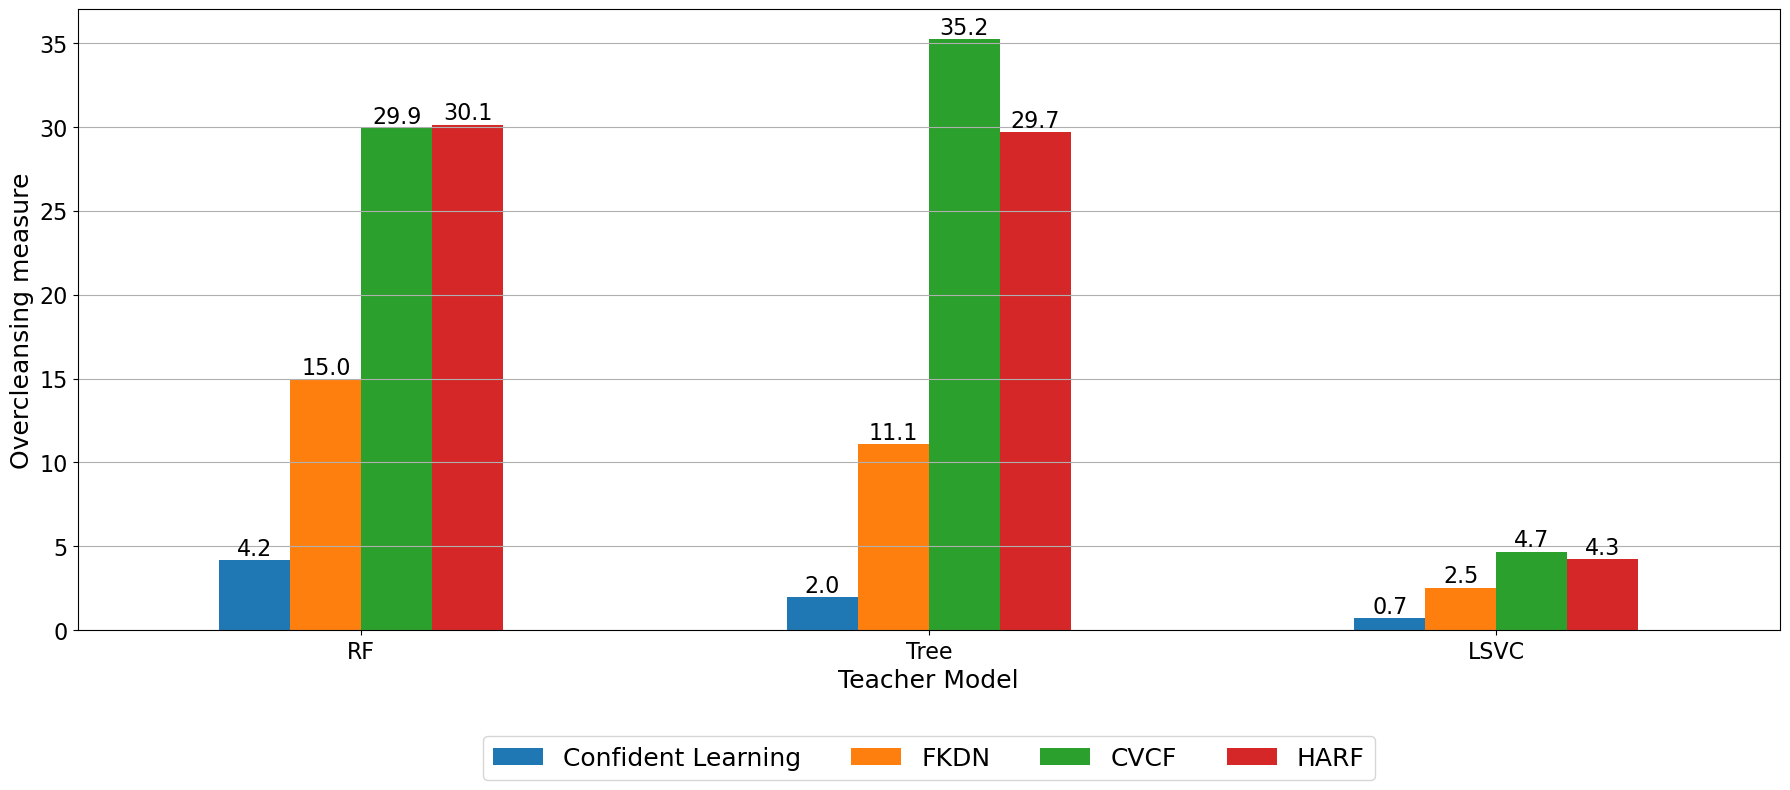

In [5]:
df = get_overcleansing_data('music')

plot_data(df)

# wdc-almser

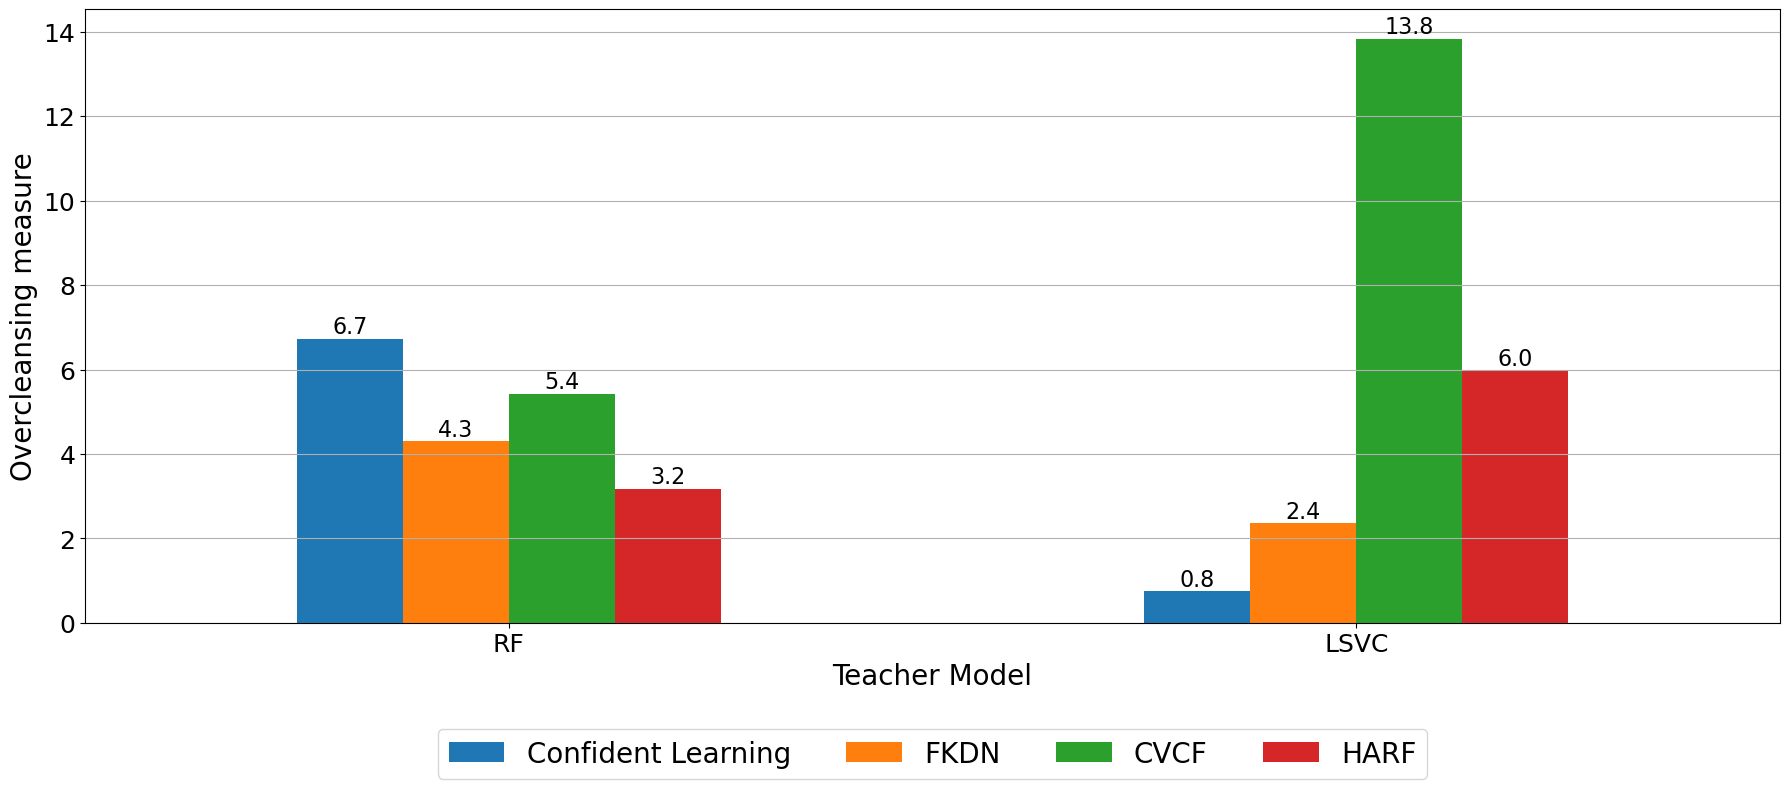

In [6]:
plt.rcParams.update({
    'axes.titlesize': 22,   
    'axes.labelsize': 20,   
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 20   
}) 

df = get_overcleansing_data('wdc_almser')

df = df[df["dataset_formatted"] != 'tree']

plot_data(df, ["rf", "svm"])

# dexter

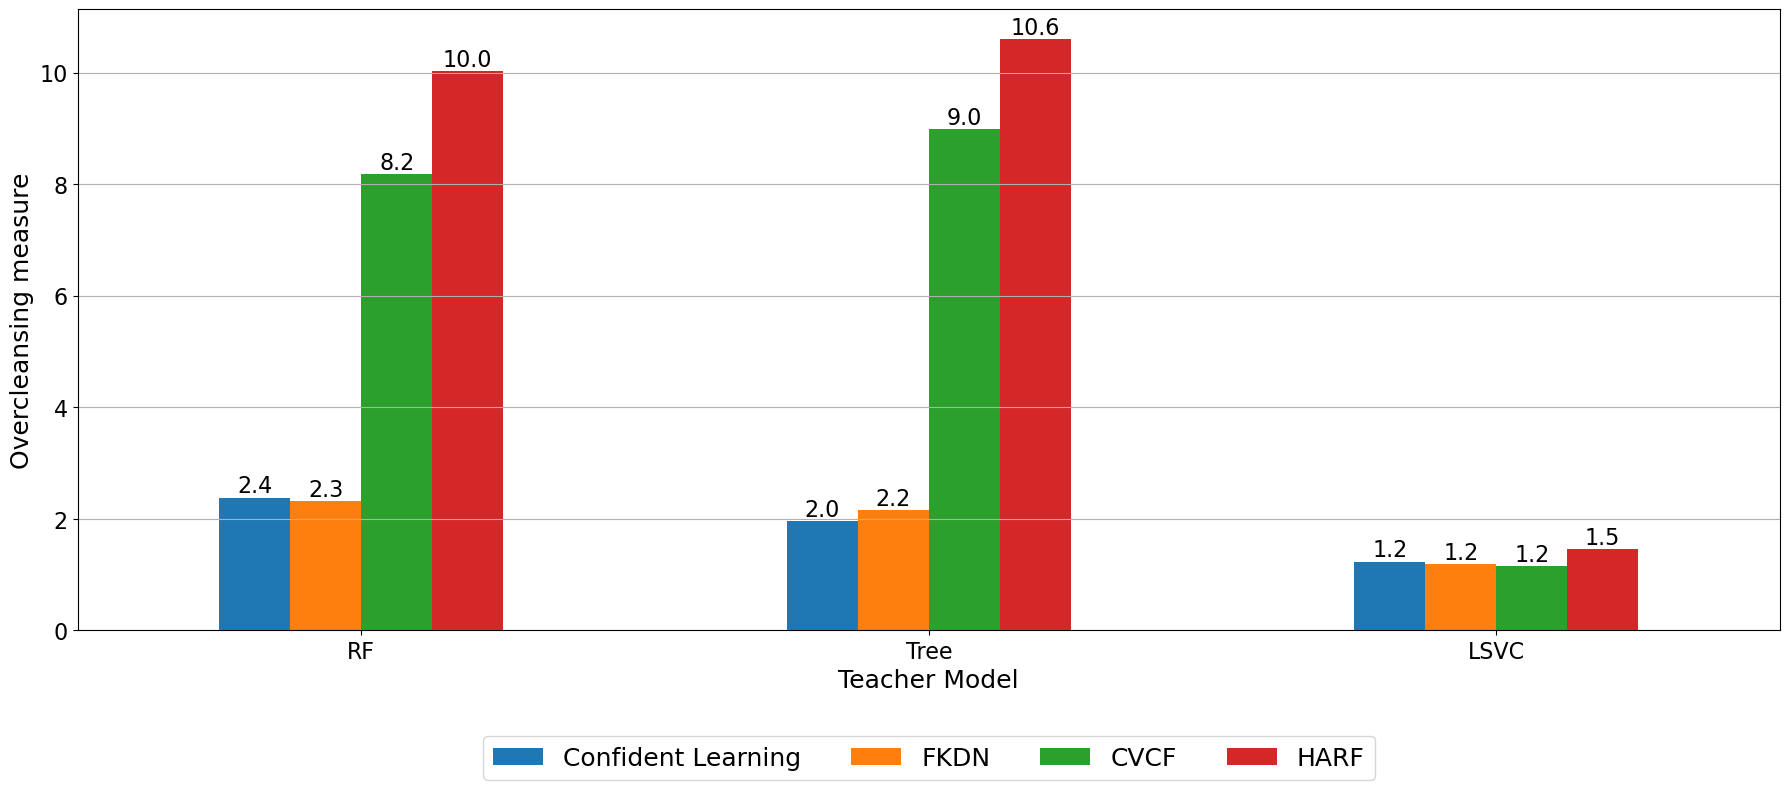

In [7]:
plt.rcParams.update(FONT_SIZE_PARAMS) 

df = get_overcleansing_data('dexter')

plot_data(df)

# Binary Conf Learn Adjustment

In [8]:
plt.rcParams.update({
    'axes.titlesize': 24,   
    'axes.labelsize': 22,   
    'xtick.labelsize': 20,  
    'ytick.labelsize': 20,  
    'legend.fontsize': 22   
}) 

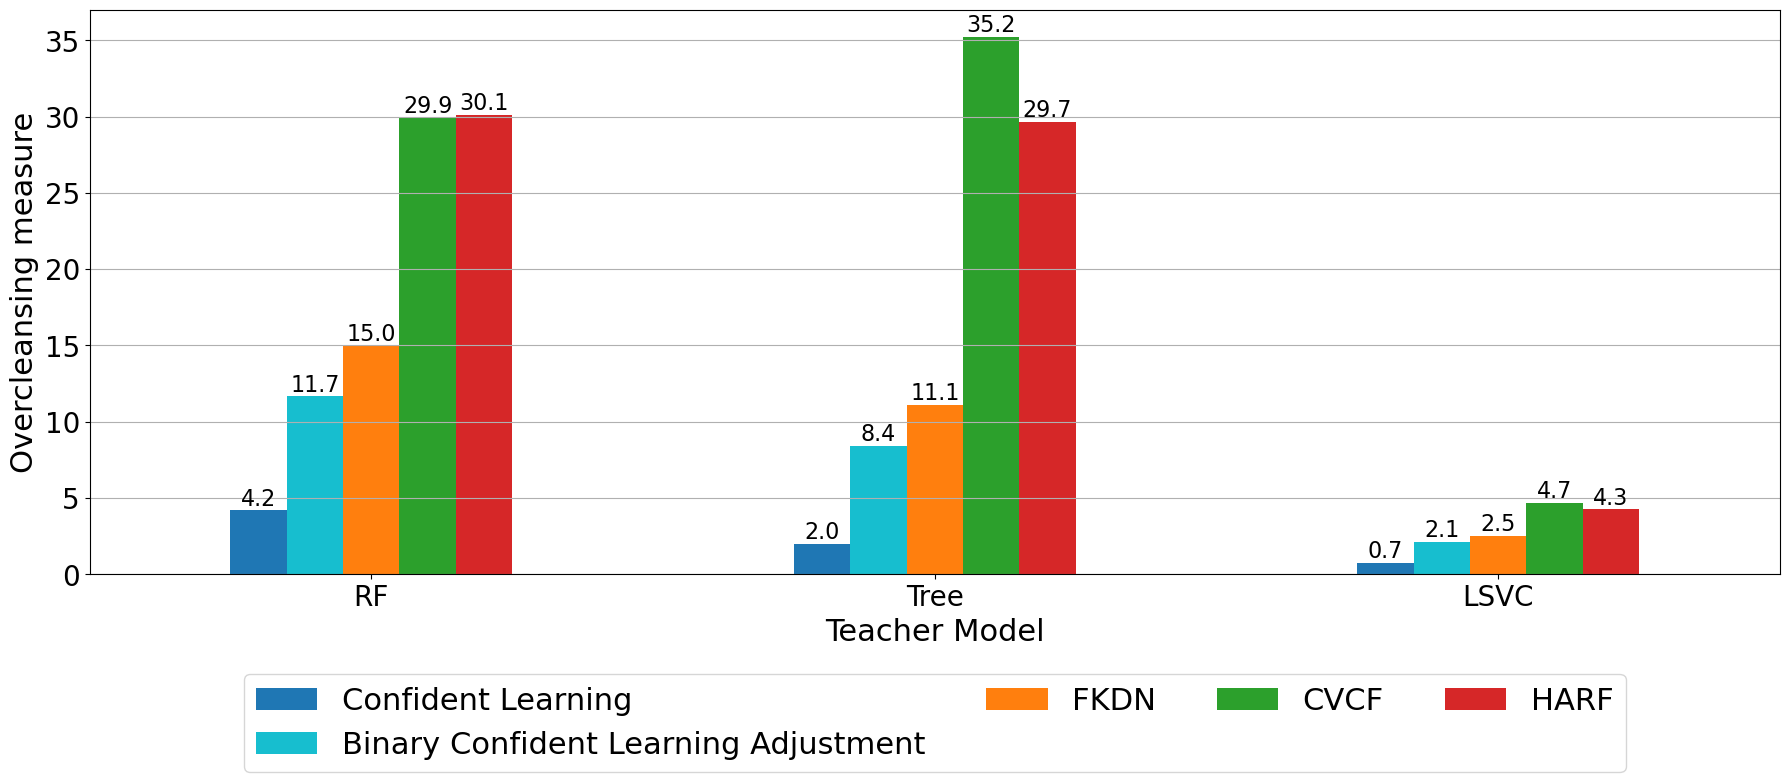

In [9]:
df = get_overcleansing_data('music')

plot_data(df, with_binary_conf_learn_adjustment=True)

# balanced overcleansing music

In [10]:
import json

def get_teacher(dataset):
    if 'rf' in dataset:
        return 'rf'
    if 'svm' in dataset:
        return 'svm'
    if 'tree' in dataset:
        return 'tree'

with open('../../results/evaluation_music/cvcf_balanced_overcleansing.json', 'r') as f:
    cvcf = json.load(f)
    cvcf = [{'teacher': get_teacher(data["dataset"]), 'detector': data["detector"], "proportion": data["cleaning"]["fp_proportion"]} for data in cvcf]

with open('../../results/evaluation_music/harf_balanced_overcleansing.json', 'r') as f:
    harf = json.load(f)
    harf = [{'teacher': get_teacher(data["dataset"]), 'detector': data["detector"], "proportion": data["cleaning"]["fp_proportion"]} for data in harf]

with open('../../results/evaluation_music/conf_learn_fkdn_balanced_overcleansing.json', 'r') as f:
    results = json.load(f)


In [11]:
data = results + cvcf + harf

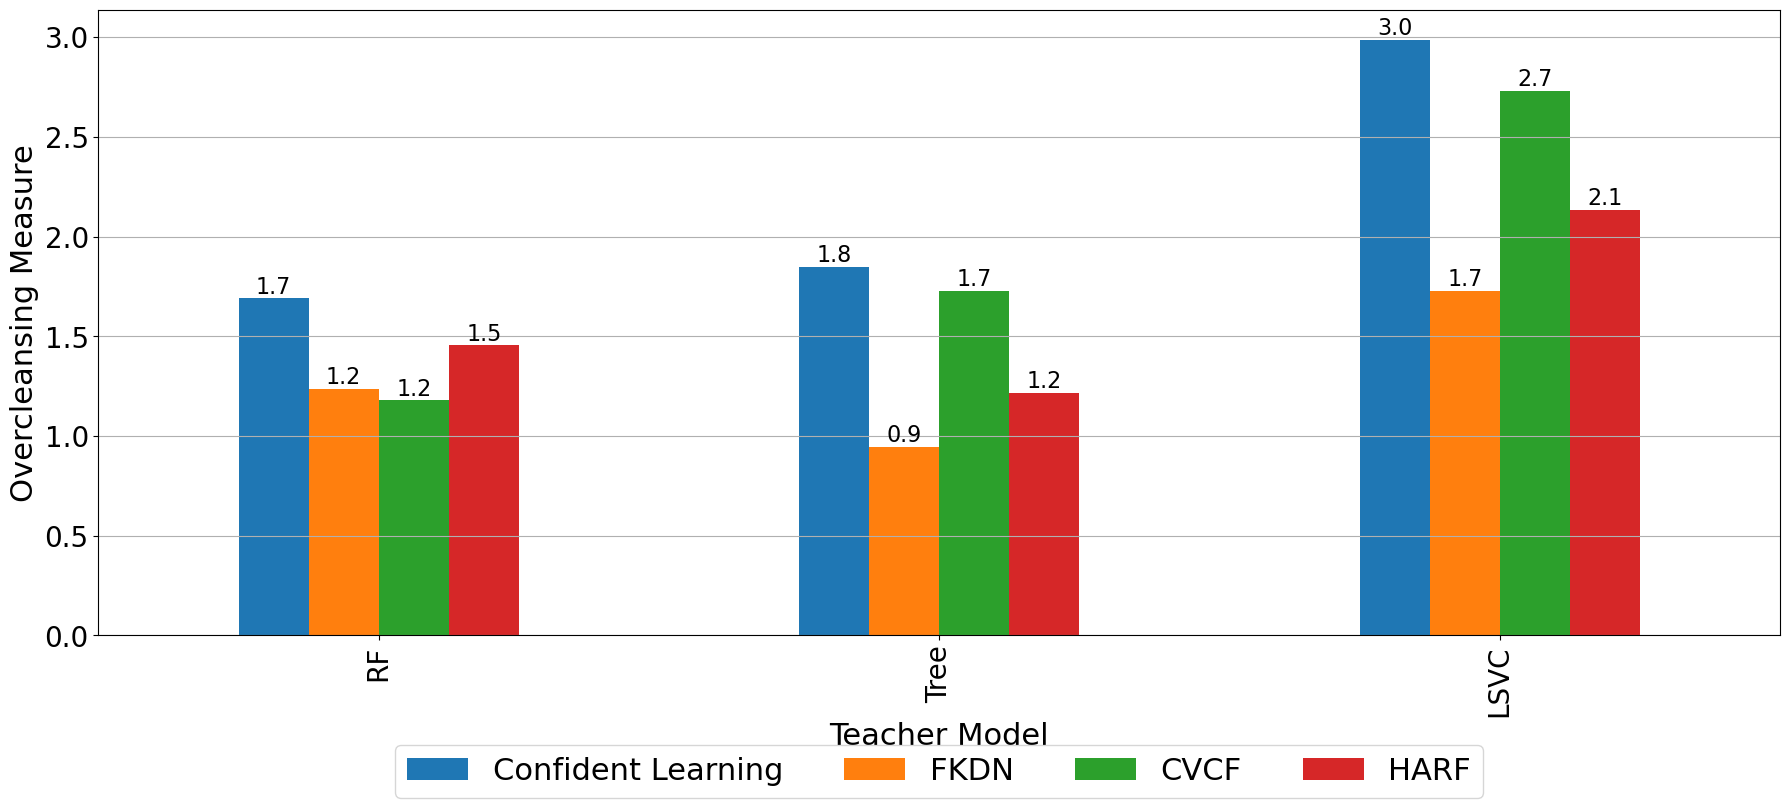

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(data)

lookup = {
    'conf_learn': 'Confident Learning',
    'fkdn': 'FKDN',
    'cvcf': 'CVCF',
    'harf': 'HARF',
    'arguable_conf_learn': 'Binary Confident Learning Adjustment',
}

df['detector'] = df['detector'].replace(lookup)

pivot_df = df.pivot(index='teacher', columns='detector', values='proportion')

pivot_df = pivot_df.rename(index={
        "rf": "RF",
        "tree": "Tree",
        "svm": "LSVC"
    })


pivot_df = pivot_df[["Confident Learning", "FKDN", "CVCF", 'HARF']]
pivot_df = pivot_df.reindex(['RF', 'Tree', 'LSVC'])

ax = pivot_df.plot(kind='bar', figsize=figsize)

plt.xlabel("Teacher Model")
plt.ylabel("Overcleansing Measure")
plt.grid(True, axis='y')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(pivot_df.columns))

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.1f}',
                ha='center',
                va='bottom',
                fontsize=16
            )

plt.subplots_adjust(bottom=0.25)

plt.tight_layout()
plt.show()
